In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import array_to_img
import os
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
import json
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score


In [2]:
# !nvidia-smi

In [3]:

def load_dataset(directory):
    images, labels = [], []
    categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
    
    for category in categories:
        path_to_category = os.path.join(directory, category)
        if os.path.isdir(path_to_category):
            for file in os.listdir(path_to_category):
                full_path = os.path.join(path_to_category, file)
                if os.path.isfile(full_path):
                    with Image.open(full_path) as img:
                        img = img.resize((128, 128)).convert('RGB')
                        images.append(np.array(img))
                        labels.append(category)
    return images, labels

def convert_labels_to_one_hot(labels):
    if not labels:
        raise ValueError("No labels found. Ensure the dataset is loaded correctly.")
    label_encoder = OneHotEncoder(sparse_output=False)
    labels_as_array = np.array(labels).reshape(-1, 1)
    one_hot_labels = label_encoder.fit_transform(labels_as_array)
    return one_hot_labels


In [4]:
# Load training data
training_folder = 'archive/Training'
train_images, train_labels = load_dataset(training_folder)
train_labels_one_hot = convert_labels_to_one_hot(train_labels) #convert the test label to one hot encoded vector


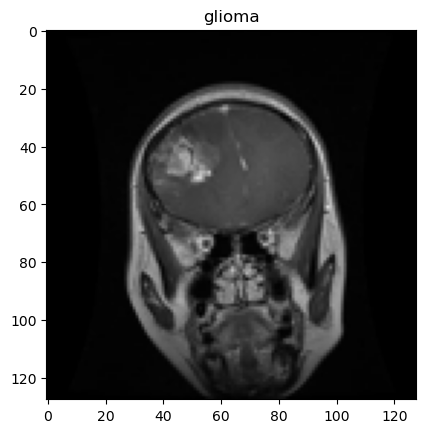

In [5]:
plt.imshow(train_images[0])
plt.title(train_labels[0])
plt.show()

In [6]:
# Load testing data
testing_folder = 'archive/Testing'
test_images, test_labels = load_dataset(testing_folder)
test_labels_one_hot = convert_labels_to_one_hot(test_labels) #convert the test label to one hot encoded vector


In [7]:
# Converting images to numpy arrays and normalize
train_images = np.array(train_images) / 255.0
test_images = np.array(test_images) / 255.0


In [8]:

print(f"Training data shape: {train_images.shape}, Training labels shape: {train_labels_one_hot.shape}")
print(f"Testing data shape: {test_images.shape}, Testing labels shape: {test_labels_one_hot.shape}")



Training data shape: (5712, 128, 128, 3), Training labels shape: (5712, 4)
Testing data shape: (1311, 128, 128, 3), Testing labels shape: (1311, 4)


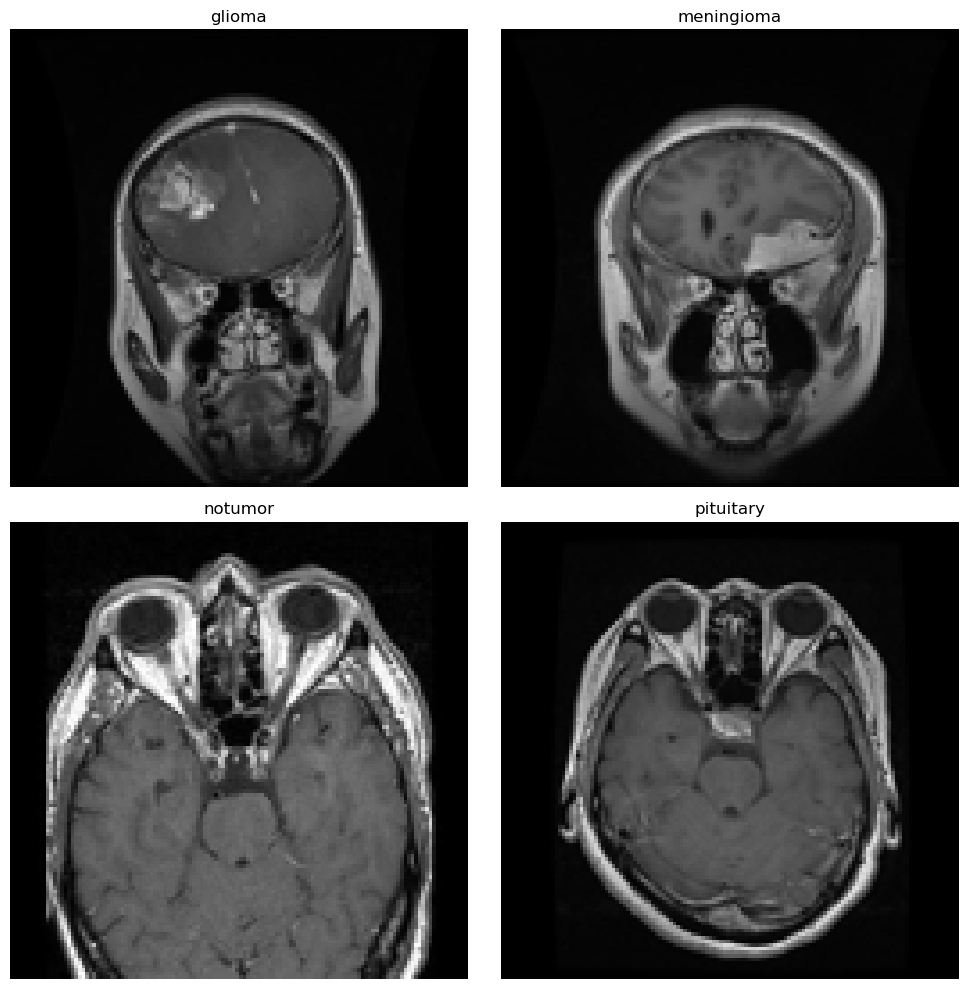

In [11]:
class_images = {}
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Iterate through the images and their corresponding labels
for img, label in zip(train_images, train_labels):
    if label not in class_images:  # If we haven't stored an image for this class yet
        class_images[label] = img
    if len(class_images) == len(class_labels):  # If we've collected one image for each class, stop
        break

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()

# Iterate through the class_images dictionary and plot one image for each class
for i, label in enumerate(class_labels):
    img = class_images[label]
    # Display the image on the corresponding subplot
    axes[i].imshow(img)
    # Set the title to the corresponding class label
    axes[i].set_title(label)
    # Remove the axis ticks
    axes[i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

In [12]:
# Shuffle training data and labels
shuffle_index = np.random.permutation(len(train_images))
train_images = train_images[shuffle_index]
train_labels_one_hot = train_labels_one_hot[shuffle_index]


In [13]:
# Define class labels
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

### Plotting some of the images

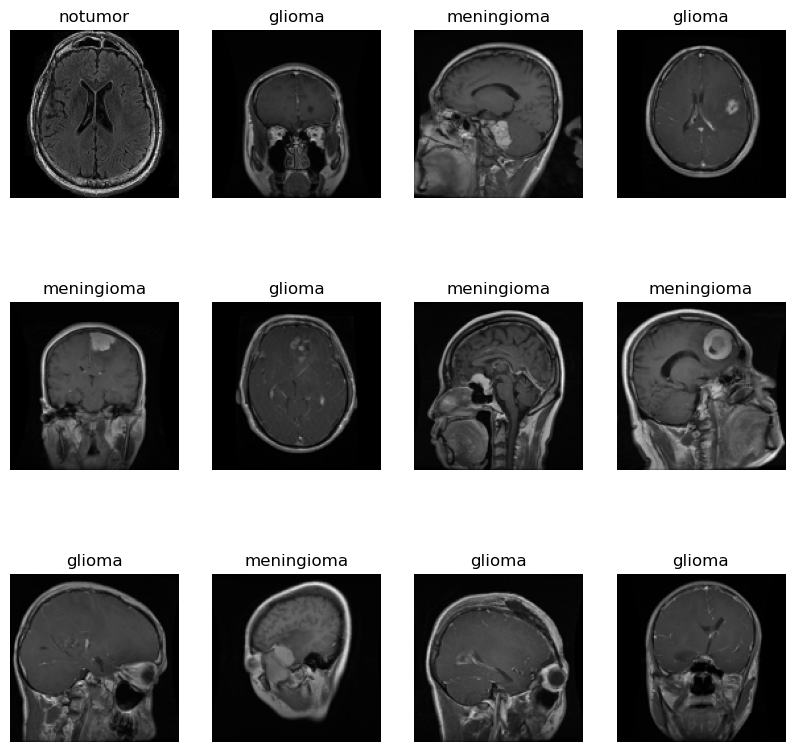

In [14]:
plt.figure(figsize=(10, 10))
indices = np.random.choice(len(train_images), 12, replace=False)

for i, idx in enumerate(indices):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(train_images[idx])
    plt.title(class_labels[np.argmax(train_labels_one_hot[idx])])
    plt.axis('off')

plt.show()

## Data Augmentation

In [15]:

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(train_images)


In [16]:
train_generator = datagen.flow(train_images, train_labels_one_hot, batch_size=32)

## RESNET

In [18]:
# Define paths for saved models
input_path = 'RESNET/saved-model/'
working_path = 'RESNET/working-model/'

# Custom callback to print when the model is saved
class MyModelCheckpoint(ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        if self.save_best_only:
            current_value = logs.get(self.monitor)
            if current_value == self.best:
                print(f"Epoch {epoch + 1}: {self.monitor} improved to {current_value}, saving model weights to {self.filepath}")
                # Save model weights
                model.save_weights(os.path.join(working_path, 'best_model_weights.weights.h5'))
                
                # Save model architecture
                model_json = model.to_json()
                with open(os.path.join(working_path, 'best_model_architecture.json'), 'w') as json_file:
                    json_file.write(model_json)


In [19]:

# Function to load model if files exist
def load_model_if_exists(model_path, weight_file, arch_file):
    if os.path.exists(weight_file) and os.path.exists(arch_file):
        with open(arch_file, 'r') as json_file:
            loaded_model_json = json_file.read()
        loaded_model = tf.keras.models.model_from_json(loaded_model_json)
        loaded_model.load_weights(weight_file)
        print("Model loaded from saved files.")
        return loaded_model
    return None


def convert_tensor_to_list(value):
    if isinstance(value, tf.Tensor):
        return value.numpy().tolist()
    return value

In [20]:

# Check if saved model exists and load it
model = load_model_if_exists(
    working_path, 
    os.path.join(working_path, 'best_model_weights.weights.h5'), 
    os.path.join(working_path, 'best_model_architecture.json')
)

if model is None:
    model = load_model_if_exists(
        input_path, 
        os.path.join(input_path, 'best_model_weights.weights.h5'), 
        os.path.join(input_path, 'best_model_architecture.json')
    )
    if model:
        with open(os.path.join(input_path, 'history.json'), 'r') as file:
            history = json.load(file)


In [21]:

if model is None:
    print("No saved model found. Training a new model...")

    # Load ResNet50 model without the top layers and with pre-trained weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(4, activation='softmax')(x)  # Change the number of classes to 4

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy',
                            tf.keras.metrics.AUC(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.F1Score()])

    # Define ModelCheckpoint callback to save the best model
    checkpoint = MyModelCheckpoint(
        filepath='best_model.keras', 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max', 
        verbose=1
    )

    # Train the model and save training history
    history = model.fit(
        train_images, 
        train_labels_one_hot, 
        epochs=10,
        batch_size=32,
        validation_data=(test_images, test_labels_one_hot), 
        callbacks=[checkpoint]
    )

    # Save training history
    history_dict = {}
    for key, value in history.history.items():
        history_dict[key] = [convert_tensor_to_list(val) for val in value]

    with open(os.path.join(working_path, 'history.json'), 'w') as file:
        json.dump(history_dict, file)

    # Verify if the model files were saved successfully
    if os.path.exists(os.path.join(working_path, 'best_model_weights.weights.h5')) and os.path.exists(os.path.join(working_path, 'best_model_architecture.json')):
        print("Model saved successfully.")
    else:
        print("Model was not saved.")


No saved model found. Training a new model...
Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.4734 - auc: 0.7439 - f1_score: 0.4524 - loss: 1.1500 - precision: 0.7362 - recall: 0.2196
Epoch 1: val_accuracy improved from -inf to 0.58581, saving model to best_model.keras
Epoch 1: val_accuracy improved to 0.5858123302459717, saving model weights to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 121s 574ms/step - accuracy: 0.4739 - auc: 0.7443 - f1_score: 0.4530 - loss: 1.1493 - precision: 0.7364 - recall: 0.2201 - val_accuracy: 0.5858 - val_auc: 0.8427 - val_f1_score: 0.5735 - val_loss: 0.9402 - val_precision: 0.6916 - val_recall: 0.3661
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.6761 - auc: 0.8913 - f1_score: 0.6701 - loss: 0.8108 - precision: 0.7780 - recall: 0.4949
Epoch 2: val_accuracy improved from 0.58581 to 0.69489, saving model to best_model.keras
Epoch 2: val_accuracy improved to 0.6948894262313843, saving model weights to best_model.ke

## Evaluation:

In [22]:
# Evaluate the model on the test data
test_loss_res, test_accuracy_res = model.evaluate(test_images, test_labels_one_hot, verbose=2)[:2]
print(f"Test Loss: {test_loss_res}")
print(f"Test Accuracy: {test_loss_res}")

# Get the predicted labels
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_one_hot, axis=1)

# Calculate precision, recall, and F1 score
precision_res = precision_score(true_labels, predicted_labels, average='weighted')
recall_res = recall_score(true_labels, predicted_labels, average='weighted')
f1_res = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision_res}")
print(f"Recall: {recall_res}")
print(f"F1 Score: {f1_res}")


41/41 - 18s - 447ms/step - accuracy: 0.7468 - auc: 0.9240 - f1_score: 0.7294 - loss: 0.6654 - precision: 0.7771 - recall: 0.7048
Test Loss: 0.6654045581817627
Test Accuracy: 0.6654045581817627
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 468ms/step
Precision: 0.7559465550837946
Recall: 0.7467581998474447
F1 Score: 0.7358716161944318


In [23]:
# classification report
print(classification_report(true_labels, predicted_labels))


              precision    recall  f1-score   support

           0       0.74      0.74      0.74       300
           1       0.69      0.46      0.55       306
           2       0.70      0.99      0.82       405
           3       0.92      0.72      0.81       300

    accuracy                           0.75      1311
   macro avg       0.76      0.73      0.73      1311
weighted avg       0.76      0.75      0.74      1311



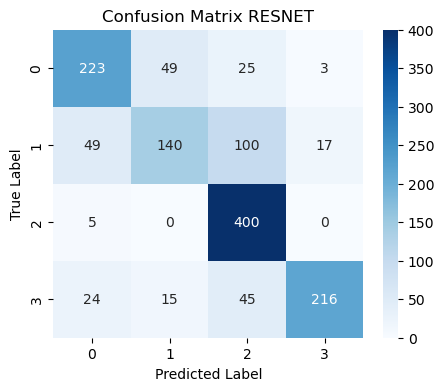

In [24]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
# print(conf_matrix)

# Visualize the confusion matrix (optional)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix RESNET')
plt.show()

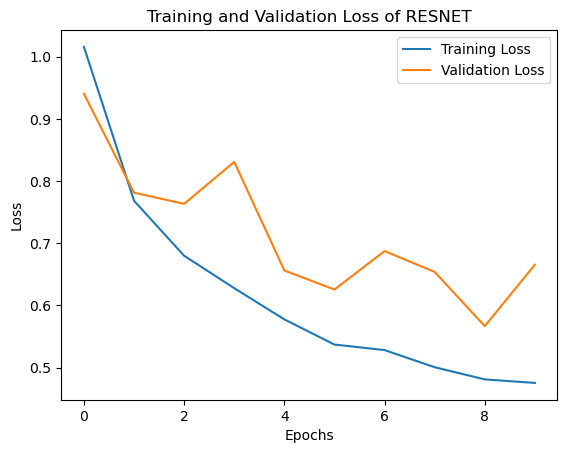

In [27]:
# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss of RESNET')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## GoogleNet Inception V3

In [41]:
# Define paths for saved models
input_path = 'GoogleNet/saved-model/'
working_path = 'GoogleNet/working-model/'


# Check if saved model exists and load it
model = load_model_if_exists(
    working_path, 
    os.path.join(working_path, 'best_model_weights.weights.h5'), 
    os.path.join(working_path, 'best_model_architecture.json')
)

if model is None:
    model = load_model_if_exists(
        input_path, 
        os.path.join(input_path, 'best_model_weights.weights.h5'), 
        os.path.join(input_path, 'best_model_architecture.json')
    )
    if model:
        with open(os.path.join(input_path, 'history.json'), 'r') as file:
            history = json.load(file)


Model loaded from saved files.


In [42]:

if model is None:
    print("No saved model found. Training a new model...")

    # Load InceptionV3 model without the top layers and with pre-trained weights
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(4, activation='softmax')(x)  # Change the number of classes to 4

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy',
                            tf.keras.metrics.AUC(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.F1Score()])

    # Define ModelCheckpoint callback to save the best model
    checkpoint = MyModelCheckpoint(
        filepath='best_model.keras', 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max', 
        verbose=1
    )

    # Train the model and save training history
    history = model.fit(
        train_images, 
        train_labels_one_hot, 
        epochs=10,
        batch_size=32,
        validation_data=(test_images, test_labels_one_hot), 
        callbacks=[checkpoint]
    )

    # Save training history
    history_dict = {}
    for key, value in history.history.items():
        history_dict[key] = [convert_tensor_to_list(val) for val in value]

    with open(os.path.join(working_path, 'history.json'), 'w') as file:
        json.dump(history_dict, file)

    # Verify if the model files were saved successfully
    if os.path.exists(os.path.join(working_path, 'best_model_weights.weights.h5')) and os.path.exists(os.path.join(working_path, 'best_model_architecture.json')):
        print("Model saved successfully.")
    else:
        print("Model was not saved.")


## Evaluation

In [43]:
# Evaluate the model on the test data
test_loss_inc, test_accuracy_inc = model.evaluate(test_images, test_labels_one_hot, verbose=2)[:2]
print(f"Test Loss: {test_loss_inc}")
print(f"Test Accuracy: {test_accuracy_inc}")

# Get the predicted labels
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_one_hot, axis=1)

# Calculate precision, recall, and F1 score
precision_inc = precision_score(true_labels, predicted_labels, average='weighted')
recall_inc = recall_score(true_labels, predicted_labels, average='weighted')
f1_inc = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision_inc}")
print(f"Recall: {recall_inc}")
print(f"F1 Score: {f1_inc}")


41/41 - 16s - 393ms/step - accuracy: 0.9436 - auc_1: 0.9946 - f1_score: 0.9393 - loss: 0.1571 - precision_1: 0.9434 - recall_1: 0.9405
Test Loss: 0.15712851285934448
Test Accuracy: 0.9435545206069946
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 313ms/step
Precision: 0.9449632101905995
Recall: 0.9435545385202135
F1 Score: 0.9435778719401835


In [44]:
# classification report
print(classification_report(true_labels, predicted_labels))


              precision    recall  f1-score   support

           0       0.95      0.88      0.91       300
           1       0.87      0.94      0.90       306
           2       0.99      1.00      1.00       405
           3       0.95      0.94      0.95       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



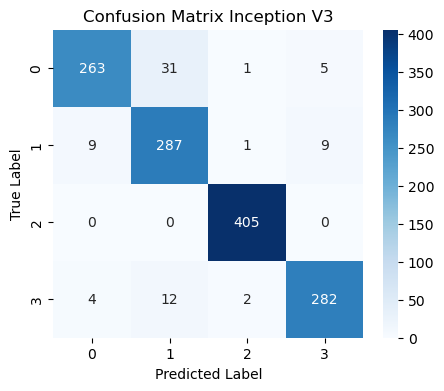

In [45]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
# print(conf_matrix)

# Visualize the confusion matrix (optional)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Inception V3')
plt.show()

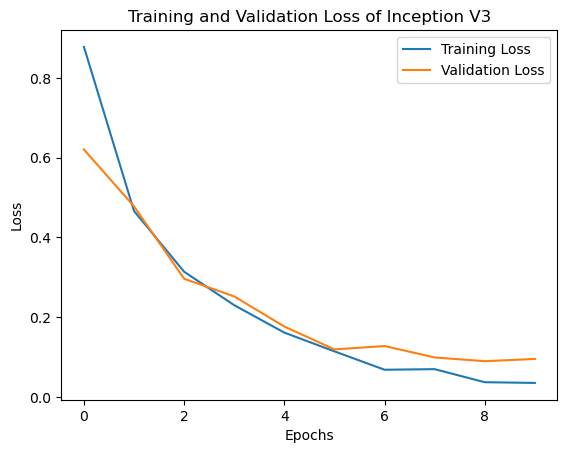

In [46]:
# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss of Inception V3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Generic Model with 5 CNNs and MaxPooling layers

In [34]:
model = models.Sequential()

# 1st Convolutional Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# 2nd Convolutional Layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 3rd Convolutional Layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 4th Convolutional Layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 5th Convolutional Layer
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and Dense Layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

model.summary()


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_94 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_96 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_98 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,062,852 (4.05 MB)

 Trainable params: 1,062,852 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Define paths for saved models
input_path = 'CustomModel/saved-model/'
working_path = 'CustomModel/working-model/'


model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.F1Score()])

# Define ModelCheckpoint callback to save the best model
checkpoint = MyModelCheckpoint(
    filepath='best_model.keras', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

# Train the model and save training history
history = model.fit(
    train_images, 
    train_labels_one_hot, 
    epochs=10,
    batch_size=32,
    validation_data=(test_images, test_labels_one_hot), 
    callbacks=[checkpoint]
)


history_dict = {}
for key, value in history.history.items():
    history_dict[key] = [convert_tensor_to_list(val) for val in value]
    
with open(os.path.join(working_path, 'history.json'), 'w') as file:
    json.dump(history_dict, file)

# Verify if the model files were saved successfully
if os.path.exists(os.path.join(working_path, 'best_model_weights.weights.h5')) and os.path.exists(os.path.join(working_path, 'best_model_architecture.json')):
    print("Model saved successfully.")
else:
    print("Model was not saved.")


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.4564 - auc_2: 0.7233 - f1_score: 0.4218 - loss: 1.1394 - precision_2: 0.6284 - recall_2: 0.2292
Epoch 1: val_accuracy improved from -inf to 0.74447, saving model to best_model.keras
Epoch 1: val_accuracy improved to 0.7444698810577393, saving model weights to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 46s 197ms/step - accuracy: 0.4573 - auc_2: 0.7241 - f1_score: 0.4228 - loss: 1.1379 - precision_2: 0.6293 - recall_2: 0.2305 - val_accuracy: 0.7445 - val_auc_2: 0.9324 - val_f1_score: 0.7222 - val_loss: 0.6208 - val_precision_2: 0.7709 - val_recall_2: 0.6957
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8042 - auc_2: 0.9525 - f1_score: 0.7884 - loss: 0.5175 - precision_2: 0.8254 - recall_2: 0.7698
Epoch 2: val_accuracy improved from 0.74447 to 0.81083, saving model to best_model.keras
Epoch 2: val_accuracy improved to 0.8108314275741577, saving model weights to best_model.keras
179/179 ━━━━━━━━━━━

In [37]:
# Evaluate the model on the test data
test_loss_generic, test_accuracy_generic = model.evaluate(test_images, test_labels_one_hot, verbose=2)[:2]
print(f"Test Loss: {test_loss_generic}")
print(f"Test Accuracy: {test_accuracy_generic}")

# Get the predicted labels
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_one_hot, axis=1)

# Calculate precision, recall, and F1 score
precision_custom = precision_score(true_labels, predicted_labels, average='weighted')
recall_custom = recall_score(true_labels, predicted_labels, average='weighted')
f1_custom = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision_custom}")
print(f"Recall: {recall_custom}")
print(f"F1 Score: {f1_custom}")


41/41 - 3s - 63ms/step - accuracy: 0.9664 - auc_2: 0.9978 - f1_score: 0.9646 - loss: 0.0950 - precision_2: 0.9664 - recall_2: 0.9657
Test Loss: 0.09498701989650726
Test Accuracy: 0.966437816619873
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Precision: 0.9666761896058257
Recall: 0.9664378337147216
F1 Score: 0.9664133825498504


In [38]:
# classification report
print(classification_report(true_labels, predicted_labels))


              precision    recall  f1-score   support

           0       0.97      0.93      0.95       300
           1       0.92      0.94      0.93       306
           2       0.98      1.00      0.99       405
           3       0.99      0.98      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.96      0.96      1311
weighted avg       0.97      0.97      0.97      1311



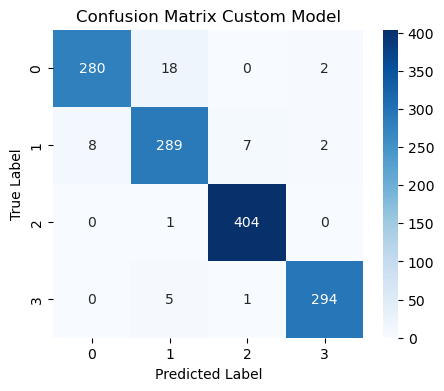

In [39]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
# print(conf_matrix)

# Visualize the confusion matrix (optional)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Custom Model')
plt.show()

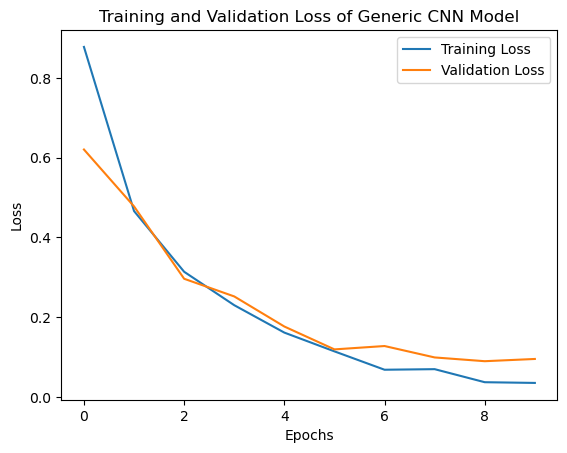

In [40]:
# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss of Generic CNN Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [50]:

eval_data = {
    'Model': ['RESNET', 'INCEPTION V3', 'Custom Model'],
    'Accuracy': [test_accuracy_res, test_accuracy_inc, test_accuracy_custom],
    'Precision': [precision_res, precision_inc, precision_custom],
    'Recall': [recall_res, recall_inc, recall_custom],
    'F1 Score': [f1_res, f1_inc, f1_custom]
}

df = pd.DataFrame(eval_data)



In [51]:
df

,Model,Accuracy,Precision,Recall,F1 Score
0,RESNET,0.758200,0.777209,0.758200,0.755301
1,INCEPTION V3,0.944317,0.945412,0.944317,0.944038
2,Custom Model,0.972540,0.972647,0.972540,0.972513


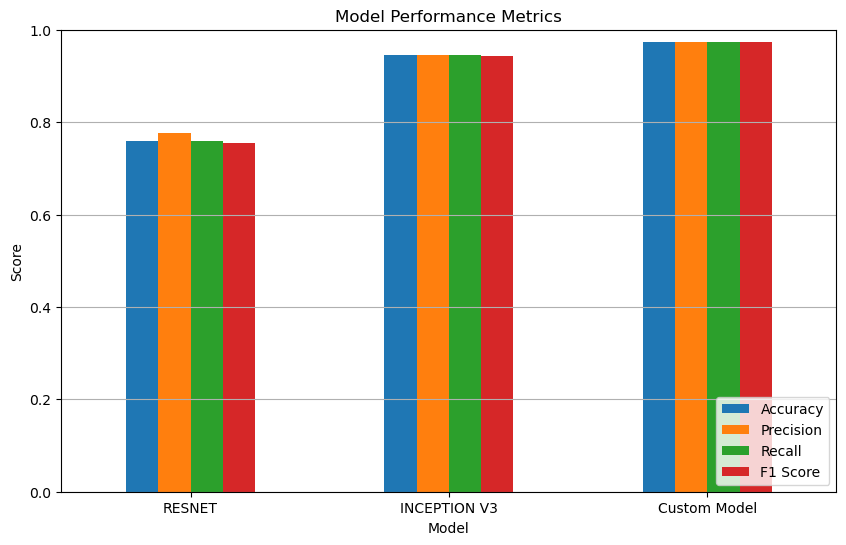

In [52]:

# Create a bar plot
df.set_index('Model').plot(kind='bar', figsize=(10, 6))

plt.title('Model Performance Metrics')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()
